## Download Necessary Files

In [1]:
from google_drive_downloader import GoogleDriveDownloader as gdd

# downloading original data set 
gdd.download_file_from_google_drive(file_id='17cM4_w3VVENzg0ZoO4UhLYSLLjzUQRNf',
dest_path='./project-files.zip')

!unzip -qq ./project-files.zip  -d ./

!rm project-files.zip 

## Prepare Works

In [2]:
%pylab inline
import time
import os 
image_dir = 'Images/'
model_dir = 'Models/'
texture_dir = 'Texture/'

import math
import numbers
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

import torchvision
from torchvision import transforms

from PIL import Image
from collections import OrderedDict

Populating the interactive namespace from numpy and matplotlib


In [3]:
#vgg definition that conveniently let's you grab the outputs from any layer
class VGG(nn.Module):
    def __init__(self, pool='max'):
        super(VGG, self).__init__()
        #vgg modules
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        if pool == 'max':
            self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        elif pool == 'avg':
            self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool3 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool4 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool5 = nn.AvgPool2d(kernel_size=2, stride=2)
            
    def forward(self, x, out_keys):
        out = {}
        out['r11'] = F.relu(self.conv1_1(x))
        out['r12'] = F.relu(self.conv1_2(out['r11']))
        out['p1'] = self.pool1(out['r12'])
        out['r21'] = F.relu(self.conv2_1(out['p1']))
        out['r22'] = F.relu(self.conv2_2(out['r21']))
        out['p2'] = self.pool2(out['r22'])
        out['r31'] = F.relu(self.conv3_1(out['p2']))
        out['r32'] = F.relu(self.conv3_2(out['r31']))
        out['r33'] = F.relu(self.conv3_3(out['r32']))
        out['r34'] = F.relu(self.conv3_4(out['r33']))
        out['p3'] = self.pool3(out['r34'])
        out['r41'] = F.relu(self.conv4_1(out['p3']))
        out['r42'] = F.relu(self.conv4_2(out['r41']))
        out['r43'] = F.relu(self.conv4_3(out['r42']))
        out['r44'] = F.relu(self.conv4_4(out['r43']))
        out['p4'] = self.pool4(out['r44'])
        out['r51'] = F.relu(self.conv5_1(out['p4']))
        out['r52'] = F.relu(self.conv5_2(out['r51']))
        out['r53'] = F.relu(self.conv5_3(out['r52']))
        out['r54'] = F.relu(self.conv5_4(out['r53']))
        out['p5'] = self.pool5(out['r54'])
        return [out[key] for key in out_keys]

In [4]:
#get network
vgg = VGG()
vgg.load_state_dict(torch.load(model_dir + 'vgg_conv.pth'))
for param in vgg.parameters():
    param.requires_grad = False
if torch.cuda.is_available():
    vgg.cuda()

In [5]:
# pre and post processing for images
# img_size = 512 
prep = transforms.Compose([# transforms.Scale(img_size),
                           transforms.ToTensor(),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), #turn to BGR
                           transforms.Normalize(mean=[0.40760392, 0.45795686, 0.48501961], #subtract imagenet mean
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x.mul_(255)),
                          ])
postpa = transforms.Compose([transforms.Lambda(lambda x: x.mul_(1./255)),
                           transforms.Normalize(mean=[-0.40760392, -0.45795686, -0.48501961], #add imagenet mean
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), #turn to RGB
                           ])
postpb = transforms.Compose([transforms.ToPILImage()])
def postp(tensor): # to clip results in the range [0,1]
    t = postpa(tensor)
    t[t>1] = 1    
    t[t<0] = 0
    img = postpb(t)
    return img

In [6]:
class GaussianSmoothing(nn.Module):
    """
    Apply gaussian smoothing on a
    1d, 2d or 3d tensor. Filtering is performed seperately for each channel
    in the input using a depthwise convolution.
    Arguments:
        channels (int, sequence): Number of channels of the input tensors. Output will
            have this number of channels as well.
        kernel_size (int, sequence): Size of the gaussian kernel.
        sigma (float, sequence): Standard deviation of the gaussian kernel.
        dim (int, optional): The number of dimensions of the data.
            Default value is 2 (spatial).
    """
    def __init__(self, channels, kernel_size, sigma, dim=2):
        super(GaussianSmoothing, self).__init__()
        if isinstance(kernel_size, numbers.Number):
            kernel_size = [kernel_size] * dim
        if isinstance(sigma, numbers.Number):
            sigma = [sigma] * dim

        # The gaussian kernel is the product of the
        # gaussian function of each dimension.
        kernel = 1
        meshgrids = torch.meshgrid(
            [
                torch.arange(size, dtype=torch.float32)
                for size in kernel_size
            ]
        )
        for size, std, mgrid in zip(kernel_size, sigma, meshgrids):
            mean = (size - 1) / 2
            kernel *= 1 / (std * math.sqrt(2 * math.pi)) * \
                      torch.exp(-((mgrid - mean) / std) ** 2 / 2)

        # Make sure sum of values in gaussian kernel equals 1.
        kernel = kernel / torch.sum(kernel)

        # Reshape to depthwise convolutional weight
        kernel = kernel.view(1, 1, *kernel.size())
        kernel = kernel.repeat(channels, *[1] * (kernel.dim() - 1))

        self.register_buffer('weight', kernel)
        self.groups = channels

        if dim == 1:
            self.conv = F.conv1d
        elif dim == 2:
            self.conv = F.conv2d
        elif dim == 3:
            self.conv = F.conv3d
        else:
            raise RuntimeError(
                'Only 1, 2 and 3 dimensions are supported. Received {}.'.format(dim)
            )

    def forward(self, input):
        """
        Apply gaussian filter to input.
        Arguments:
            input (torch.Tensor): Input to apply gaussian filter on.
        Returns:
            filtered (torch.Tensor): Filtered output.
        """
        return self.conv(input, weight=self.weight.cuda(), groups=self.groups)

## Implementation of Multi-Scale Texture Transfer 

In [7]:
# gram matrix and loss
class GramMatrix(nn.Module):
    def forward(self, input):
        b,c,h,w = input.size()
        F = input.view(b, c, h*w)
        G = torch.bmm(F, F.transpose(1,2)) 
        G.div_(h*w)
        return G

class GramMSELoss(nn.Module):
    def forward(self, input, target):
        out = nn.MSELoss()(GramMatrix()(input), target)
        return(out)

In [8]:
#load images, ordered as [style_image, content_image]
img_dirs = [texture_dir, image_dir]
img_names = ['9.jpg', 'Tuebingen_Neckarfront.jpg']
imgs = [Image.open(img_dirs[i] + name) for i,name in enumerate(img_names)]
imgs_torch = [prep(img) for img in imgs]
if torch.cuda.is_available():
    imgs_torch = [Variable(img.unsqueeze(0).cuda()) for img in imgs_torch]
else:
    imgs_torch = [Variable(img.unsqueeze(0)) for img in imgs_torch]
style_image, content_image = imgs_torch

# opt_img = Variable(torch.randn(content_image.size()).type_as(content_image.data), requires_grad=True) #random init
opt_img = Variable(content_image.data.clone(), requires_grad=True)
print(opt_img.size())

torch.Size([1, 3, 768, 1024])


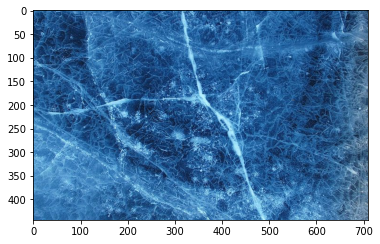

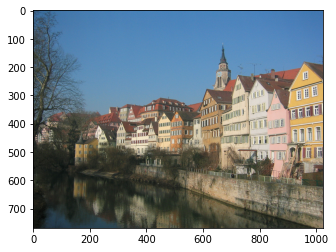

In [9]:
#display images
for img in imgs:
    imshow(img);show()

In [10]:
#define layers, loss functions, weights and compute optimization targets
style_layers = ['r11','r21','r31','r41','r51'] 
content_layers = ['r42']
loss_layers = style_layers + content_layers
loss_fns = [GramMSELoss()] * len(style_layers) + [nn.MSELoss()] * len(content_layers)
if torch.cuda.is_available():
    loss_fns = [loss_fn.cuda() for loss_fn in loss_fns]
    
#these are good weights settings:
style_weights = [1e3/n**2 for n in [64,128,256,512,512]]
content_weights = [1e0]
weights = style_weights + content_weights

#compute optimization targets
style_targets = []
content_targets = []

pyramid_level = 3
smoothing = GaussianSmoothing(3, 5, 1)
downsample = nn.Conv2d(3, 3, 1, stride=2, padding=1).cuda()

style_tmp = style_image
content_tmp = content_image
for i in range(pyramid_level):
  style_targets.append([GramMatrix()(A).detach() for A in vgg(style_tmp, style_layers)])
  content_targets.append([A.detach() for A in vgg(content_tmp, content_layers)])
  print(style_tmp.size())
  style_tmp = smoothing(style_tmp)
  style_tmp = downsample(style_tmp)
  content_tmp = smoothing(content_tmp)
  content_tmp = downsample(content_tmp)
targets = []
for i in range(pyramid_level):
  targets.append(style_targets[i] + content_targets[i])

torch.Size([1, 3, 444, 710])
torch.Size([1, 3, 221, 354])
torch.Size([1, 3, 110, 176])


Iteration: 50, loss: 3373087.250000
Iteration: 100, loss: 1116311.500000
Iteration: 150, loss: 810670.250000
Iteration: 200, loss: 674970.875000


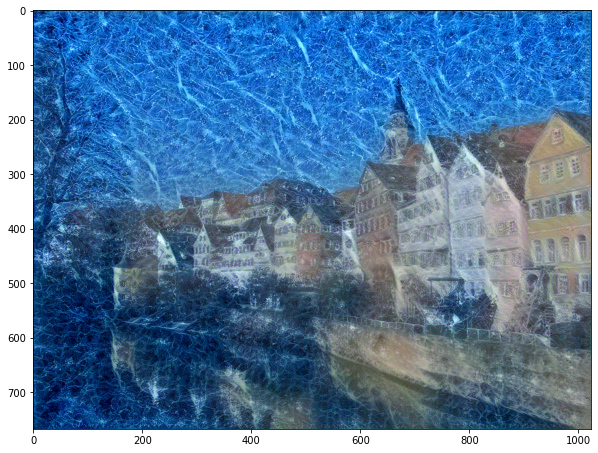

In [11]:
#run style transfer
max_iter = 200
show_iter = 50
optimizer = optim.LBFGS([opt_img]);
n_iter=[0]

while n_iter[0] <= max_iter:

    def closure():
        optimizer.zero_grad()
        loss = 0
        opt_tmp = opt_img
        for i in range(pyramid_level):
          out = vgg(opt_tmp, loss_layers)
          layer_losses = [weights[a] * loss_fns[a](A, targets[i][a]) for a,A in enumerate(out)]
          loss = loss + sum(layer_losses)
          opt_tmp = smoothing(opt_tmp)
          opt_tmp = downsample(opt_tmp)

        loss.backward()
        n_iter[0]+=1
        #print loss
        if n_iter[0]%show_iter == (show_iter-1):
            print('Iteration: %d, loss: %f'%(n_iter[0]+1, loss.data.item()))
#             print([loss_layers[li] + ': ' +  str(l.data[0]) for li,l in enumerate(layer_losses)]) #loss of each layer
        return loss

    optimizer.step(closure)
    
#display result
out_img = postp(opt_img.data[0].cpu().squeeze())
imshow(out_img)
gcf().set_size_inches(10,10)

## Implementation of Texture Generation

Here we do not use a great image to show the difference between algorithms.

In [27]:
# Create a same-texture image.
# Applying the algo on a random image
from PIL import Image
from matplotlib import cm

img_dirs = [texture_dir]
img_names = ['12.jpg']
imgs = [Image.open(img_dirs[i] + name) for i,name in enumerate(img_names)]
stl = Variable(prep(imgs[0]).data.clone(), requires_grad=True)
print(stl.shape)

random_array = np.random.rand(stl.shape[1], stl.shape[2])
img_random = Image.fromarray(np.uint8(cm.gist_earth(random_array)*255))
# imshow(img_random);show()

imgs.append(img_random)
imgs_torch = [prep(img) for img in imgs]
if torch.cuda.is_available():
    imgs_torch = [Variable(img.unsqueeze(0).cuda()) for img in imgs_torch]
else:
    imgs_torch = [Variable(img.unsqueeze(0)) for img in imgs_torch]
style_image, content_image = imgs_torch
opt_img = Variable(content_image.data.clone(), requires_grad=True)
print(opt_img.size())

torch.Size([3, 724, 1024])
torch.Size([1, 3, 724, 1024])


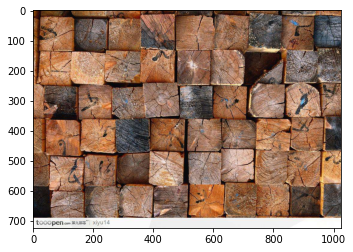

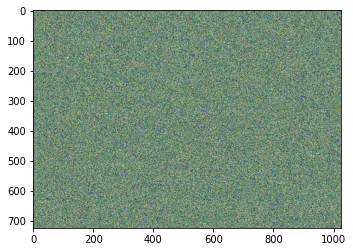

In [28]:
#display images
for img in imgs:
    imshow(img);show()

In [29]:
#define layers, loss functions, weights and compute optimization targets
style_layers = ['r11','r21','r31','r41','r51'] 
loss_layers = style_layers
loss_fns = [GramMSELoss()] * len(style_layers)
if torch.cuda.is_available():
    loss_fns = [loss_fn.cuda() for loss_fn in loss_fns]
    
#these are good weights settings:
style_weights = [1e3/n**2 for n in [64,128,256,512,512]]
weights = style_weights

#compute optimization targets
style_targets = []

pyramid_level = 1 # Could be higher to return a better result
smoothing = GaussianSmoothing(3, 5, 1)
downsample = nn.Conv2d(3, 3, 1, stride=2, padding=1).cuda()

style_tmp = style_image
for i in range(pyramid_level):
  style_targets.append([GramMatrix()(A).detach() for A in vgg(style_tmp, style_layers)])
  print(style_tmp.size())
  style_tmp = smoothing(style_tmp)
  style_tmp = downsample(style_tmp)
targets = []
for i in range(pyramid_level):
  targets.append(style_targets[i])

torch.Size([1, 3, 724, 1024])


Iteration: 50, loss: 5593771.000000
Iteration: 100, loss: 1072775.375000


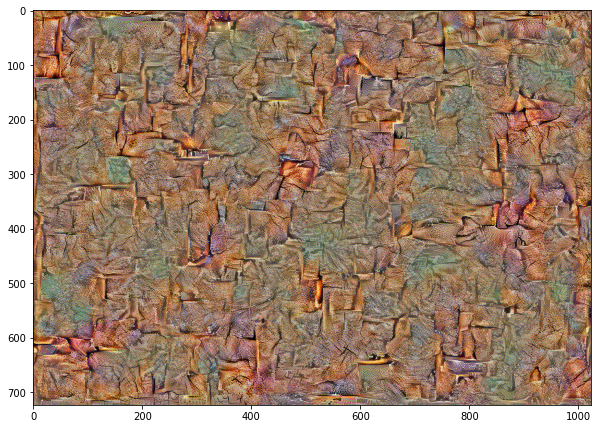

In [30]:
#run style transfer
max_iter = 100 # The higher, the better.
show_iter = 50
optimizer = optim.LBFGS([opt_img]);
n_iter=[0]

while n_iter[0] <= max_iter:

    def closure():
        optimizer.zero_grad()
        loss = 0
        opt_tmp = opt_img
        for i in range(pyramid_level):
          out = vgg(opt_tmp, loss_layers)
          layer_losses = [weights[a] * loss_fns[a](A, targets[i][a]) for a,A in enumerate(out)]
          loss = loss + sum(layer_losses)
          opt_tmp = smoothing(opt_tmp)
          opt_tmp = downsample(opt_tmp)

        loss.backward()
        n_iter[0]+=1
        #print loss
        if n_iter[0]%show_iter == (show_iter-1):
            print('Iteration: %d, loss: %f'%(n_iter[0]+1, loss.data.item()))
#             print([loss_layers[li] + ': ' +  str(l.data[0]) for li,l in enumerate(layer_losses)]) #loss of each layer
        return loss

    optimizer.step(closure)
    
#display result
out_img = postp(opt_img.data[0].cpu().squeeze())
imshow(out_img)
gcf().set_size_inches(10,10)

## Implementation of Texture Generation using Spatial Co-occurence + Multi Scale

In [23]:
# gram translation matrix and loss
class GramTraXMatrix(nn.Module):
    delta = 10
    def forward(self, input):
        b,c,h,w = input.size()
        F = input.view(b, c, h*w)
        try:
          F1 = F[:,:,0:F.shape[2]-self.delta]
          F2 = F[:,:,self.delta:F.shape[2]]
        except:
          print('delta error')
        G = torch.bmm(F1, F2.transpose(1,2)) 
        G.div_(h*w - self.delta)
        return G

class GramTraXMSELoss(nn.Module):
    def forward(self, input, target):
        out = nn.MSELoss()(GramTraXMatrix()(input), target)
        return(out)

# gram translation matrix and loss
class GramTraYMatrix(nn.Module):
    delta = 10
    def forward(self, input):
        b,c,h,w = input.size()
        F = input.view(b, c, h*w)
        try:
          F1 = F[:,0:F.shape[1]-self.delta,:]
          F2 = F[:,self.delta:F.shape[1],:]
        except:
          print("Delta Error.")
        G = torch.bmm(F1, F2.transpose(1,2)) 
        G.div_(h*w)
        return G

class GramTraYMSELoss(nn.Module):
    def forward(self, input, target):
        out = nn.MSELoss()(GramTraYMatrix()(input), target)
        return(out)

In [31]:
#define layers, loss functions, weights and compute optimization targets
style_layers = ['r11','r21','r31','r41','r51'] 
loss_layers = style_layers + style_layers + style_layers
loss_fns = [GramMSELoss()] * len(style_layers) + [GramTraXMSELoss()] * len(style_layers) + [GramTraYMSELoss()] * len(style_layers)
if torch.cuda.is_available():
    loss_fns = [loss_fn.cuda() for loss_fn in loss_fns]
    
#these are not the optimal setting!
style_weights = [1e3/n**2 for n in [64,128,256,512,512]]
style_weights_X = [1e3/n**2 for n in [64,128,256,512,512]]
style_weights_Y = [1e3/n**2 for n in [64,128,256,512,512]]
weights = style_weights + style_weights_X + style_weights_Y

#compute optimization targets
style_targets = []

pyramid_level = 3
smoothing = GaussianSmoothing(3, 5, 1)
downsample = nn.Conv2d(3, 3, 1, stride=2, padding=1).cuda()

style_tmp = style_image
for i in range(pyramid_level):
  style_targets.append([GramMatrix()(A).detach() for A in vgg(style_tmp, style_layers)])
  style_targets.append([GramTraXMatrix()(A).detach() for A in vgg(style_tmp, style_layers)])
  style_targets.append([GramTraYMatrix()(A).detach() for A in vgg(style_tmp, style_layers)])
  style_tmp = smoothing(style_tmp)
  style_tmp = downsample(style_tmp)
targets = []
for i in range(pyramid_level):
  targets.append(style_targets[3*i] + style_targets[3*i+1] + style_targets[3*i+2])

Iteration: 50, loss: 12650198.000000
Iteration: 100, loss: 5192483.000000


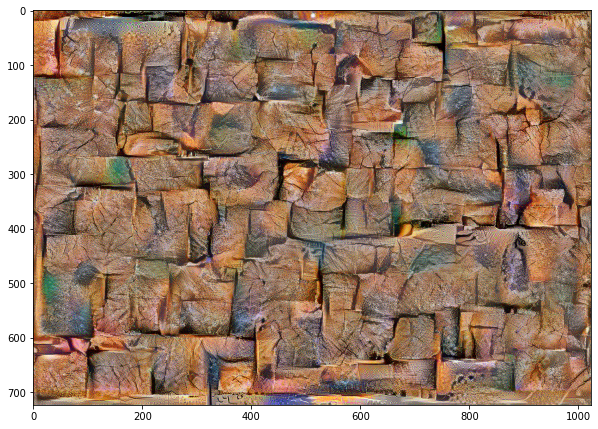

In [32]:
max_iter = 100 # The higher, the better.
show_iter = 50
optimizer = optim.LBFGS([opt_img]);
n_iter=[0]

while n_iter[0] <= max_iter:

    def closure():
        optimizer.zero_grad()
        loss = 0
        opt_tmp = opt_img
        for i in range(pyramid_level):
          out = vgg(opt_tmp, loss_layers)
          layer_losses = [weights[a] * loss_fns[a](A, targets[i][a]) for a,A in enumerate(out)]
          loss = loss + sum(layer_losses)
          opt_tmp = smoothing(opt_tmp)
          opt_tmp = downsample(opt_tmp)

        loss.backward()
        n_iter[0]+=1
        #print loss
        if n_iter[0]%show_iter == (show_iter-1):
            print('Iteration: %d, loss: %f'%(n_iter[0]+1, loss.data.item()))
#             print([loss_layers[li] + ': ' +  str(l.data[0]) for li,l in enumerate(layer_losses)]) #loss of each layer
        return loss

    optimizer.step(closure)
    
#display result
out_img_co = postp(opt_img.data[0].cpu().squeeze())
imshow(out_img_co)
gcf().set_size_inches(10,10)

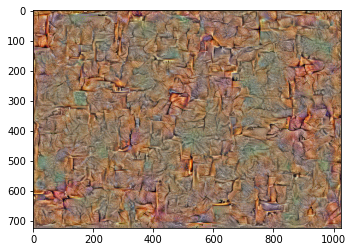

In [33]:
imshow(out_img)
show()
imshow(out_img_co)
show()